# Example of a planet in a disc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-talk')

%matplotlib inline


# The basic chemical picture

The Oberg+ 2011 type picture of a disc with the base abundances. For details see the carbon_depletion examples

In [11]:
#You can describe the chemisty directly instead -> see carbon_depletion.ipynb

from drift_composition.atoms import (
    load_protosolar_abundances,
    atoms_in_molecule, molecule_mass
)

atom_abund = load_protosolar_abundances()
grain_abund = {'MgFeSiO4' : atom_abund['O'] / 12}

def species_label(species):
    if species in ['C4H10']:
        return 'C_grain'
    else:
        return species
    
mean_mol_wgt = 2.32
dust_to_gas =0.005862


### Define constants describing the disc model

In [38]:
Mdot_gas = 1e-8          #Mass accretion rate of gas
dust_flux_factor = 1    #Dust enhancement due to radial drift
Stokes = lambda R: 0.001  #Stokes number of the dust in the disc
alpha = lambda R: 1e-3   #viscous turbulent alpha coefficient in the disc

T0    = 200              #Temperature at 1AU, note: we are working with F stars

In [39]:
from drift_composition.constants import Rau
from drift_composition.grid import Grid
from drift_composition.disc import DiscModel
from drift_composition.molecule import get_molecular_properties


grid = Grid(0.05*Rau, 300*Rau, 512) #the radial logarithmic grid

T = lambda R: T0 * (R/Rau)**(-0.5)  #the temperature function

DM = DiscModel(grid, Mdot_gas, alpha, T, mu=mean_mol_wgt)

DM.compute_dust_surface_density(Mdot_gas*dust_to_gas*dust_flux_factor, lambda R:0)

#species, abundances = get_species_info(mol_abund) #Use to initialize specific chemistry
species, abundances = get_molecular_properties()   #Use to take default solar abundances
DM.compute_chemistry(species, abundances, d2g=dust_to_gas)
mass_dir = dict(zip([spec.name for spec in species],[spec.mass_amu for spec in species]))
print('Considered molecules with atomic masses in the system:', mass_dir)

Considered molecules with atomic masses in the system: {'H2O': 18, 'CO2': 44, 'CO': 28, 'C2H6': 30, 'CH3OH': 32, 'N2': 28, 'NH3': 17, 'He': 4, 'Ar': 40, 'Kr': 84, 'Xe': 131, 'C4H10': 58}


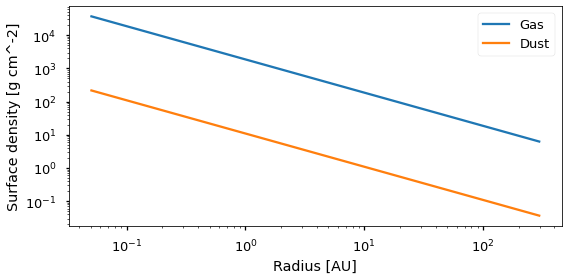

In [40]:
f, ax = plt.subplots(1, figsize=(8, 4), sharex=True)

ax.loglog(grid.Rc/Rau, DM.Sigma_gas, label='Gas')
ax.loglog(grid.Rc/Rau, DM.Sigma_dust, label='Dust')
ax.set_ylabel('Surface density [g cm^-2]')
ax.set_xlabel('Radius [AU]')

ax.legend()

f.tight_layout()

### Planet evolution

In [51]:
dt = 1000       #initial timestep in yr
Nt = 2000       #max number of timesteps
f_plansi = 1e-3 #fraction of planitesimal/dust

frac_gc = 0.01  #initial gas/core fraction of the planet
init_m  = 5.0   #initial planet mass in M_earth
init_r  = 8.0  #initial planet distance in au
m_star  = 1.4   #solar_masses

In [52]:
from drift_composition.constants import Mearth, Msun
from drift_composition.simple_planet import PlanetEnv, Planet, std_evo_comp
from drift_composition.simple_reduction import Evolution
import drift_composition.simple_graphs as sg

#calculating the local disc environment around the planet
gas = {'H2':atom_abund['H']/2,'He':atom_abund['He']} #components that make up the gas disc
dust = grain_abund                                   #components that make up the solids
dust = {n: g / np.sum(list(grain_abund.values())) for n,g in grain_abund.items()}
gas  = {n: g / np.sum(list(gas.values())) for n,g in gas.items()}
p_env = PlanetEnv(grid, alpha(grid.Rc), mean_mol_wgt, m_star, gas, dust) #create local disc properties

#initializing the planets chemical composition as zeros
f_comp = dict(zip([spec.name for spec in species],np.zeros((len(species),2))))
for g in gas:
    f_comp[g] = np.zeros(2)
for d in dust:
    f_comp[d] = np.zeros(2)

#intial planet object
planet_ini = Planet(init_m*Mearth/Msun, init_m*(1-frac_gc)*Mearth/Msun, init_m*(frac_gc)*Mearth/Msun, f_comp, init_r*Rau)

#evolving the planet in time, planet_evo is a list of Planet
planet_evo, nn = std_evo_comp(planet_ini, DM, p_env, T(grid.Rc),f_plansi, dt, Nt, final_radius = 5.5e-2)
e = Evolution(planet_evo, nn) #rearrange the data for easy plotting
print(list(e.f_comps.keys()))

accreted at t = 2236657.595765856; n= 588
['H2O', 'CO2', 'CO', 'C2H6', 'CH3OH', 'N2', 'NH3', 'He', 'Ar', 'Kr', 'Xe', 'C4H10', 'H2', 'MgFeSiO4']


The evolution will break either if the planet reachs the final_radius or if it grows beyond 5 Jupiter masses.

### Plotting the evolution and composition of the disc and the planet

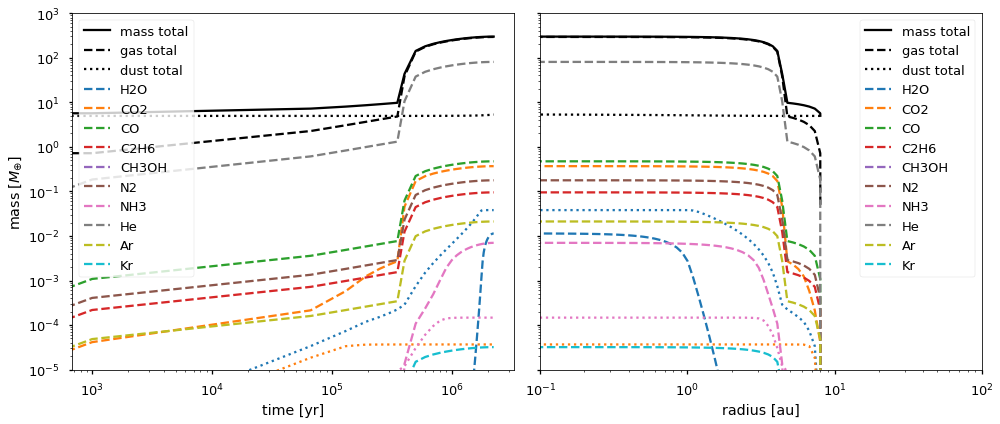

In [53]:
# same as calling sg.plot_planet(evolution)

f, ax = plt.subplots(1,2, figsize=(14, 6), sharey=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax[0].plot(e.time, e.masses*Msun/Mearth, 'k-', label='mass total')
ax[0].plot(e.time, e.mgs*Msun/Mearth, 'k--', label='gas total')
ax[0].plot(e.time, e.mcs*Msun/Mearth, 'k:', label='dust total')
for name, c in zip(list(e.f_comps.keys()),colors):
    ax[0].plot(e.time, e.f_comps[name][0]*Msun/Mearth, '--', c=c, label=name)
    ax[0].plot(e.time, e.f_comps[name][1]*Msun/Mearth, ':', c=c)
ax[0].set_ylim(1e-5,1e3)
ax[0].set_ylabel(r'mass [$M_{\oplus}$]')
ax[0].set_xlabel('time [yr]')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')


ax[1].plot(e.rs, e.masses*Msun/Mearth, 'k-', label='mass total')
ax[1].plot(e.rs, e.mgs*Msun/Mearth, 'k--', label='gas total')
ax[1].plot(e.rs, e.mcs*Msun/Mearth, 'k:', label='dust total')
for name, c in zip(list(e.f_comps.keys()),colors):
    ax[1].plot(e.rs, e.f_comps[name][0]*Msun/Mearth, '--', c=c, label=name)
    ax[1].plot(e.rs, e.f_comps[name][1]*Msun/Mearth, ':', c=c)
ax[1].set_ylim(1e-5,1e3)
ax[1].set_xlim(1e-1,1e2)
ax[1].set_xlabel('radius [au]')
#ax[1].set_ylabel(r'mass [$M_{\oplus}$]')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')
f.tight_layout()


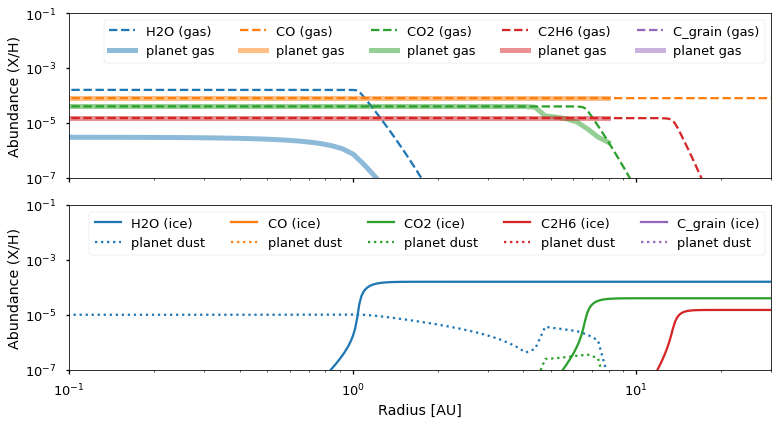

In [54]:
columns = DM.compute_molecular_column()
f, ax = plt.subplots(2, figsize=(11, 6), sharex=True)

idx = columns['CO'][:,0] > 0.5 * columns['CO'][:,1]

for spec in ['H2O', 'CO', 'CO2', 'C2H6', 'C4H10']:
    # plot disc material
    l,= ax[0].loglog(grid.Rc/Rau, 0.5*columns[spec][:,0]/columns['H2'][:,0], 
                     label=f'{species_label(spec)} (gas)',  ls='--', )
    ax[1].loglog(grid.Rc/Rau, 0.5*columns[spec][:,1]/columns['H2'][:,0], 
                 label=f'{species_label(spec)} (ice)',c=l.get_color())
    
    # plot planet mass contribution
    ax[0].plot(e.rs[1:], e.f_comps[spec][0][1:]/e.f_comps['H2'][0][1:]*(1/mass_dir[spec]), '-', alpha=0.5,lw=5, c=l.get_color(), label='planet gas')
    ax[1].plot(e.rs[1:], e.f_comps[spec][1][1:]/e.f_comps['H2'][0][1:]*(1/mass_dir[spec]), ':', c=l.get_color(), label='planet dust')
    
ax[0].set_ylabel('Abundance (X/H)')
ax[0].legend(ncol=5)
ax[0].set_ylim(1e-7, 0.1) 

ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('Abundance (X/H)')
ax[1].legend(ncol=5)
ax[1].set_ylim(1e-7, 0.1) 
ax[1].set_xlim(0.1,30)

f.tight_layout()


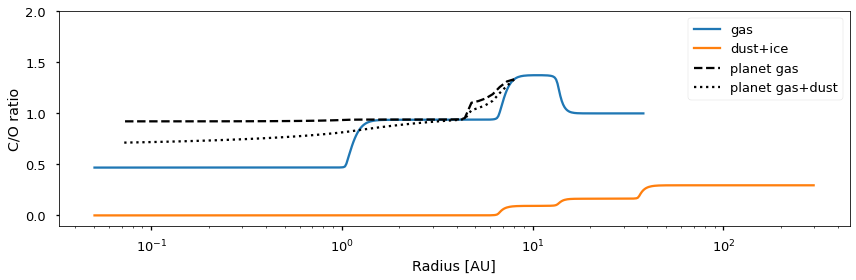

In [55]:

columns = DM.compute_elemental_column(dust=grain_abund)
C2O = columns['C']/columns['O']

columns =  DM.compute_elemental_column() 
C2O_ice = columns['C']/columns['O']

columns = DM.compute_molecular_column()
f, ax = plt.subplots(1, figsize=(12, 4), sharex=True)

ax.semilogx(grid.Rc[idx]/Rau, C2O[idx,0], label='gas')
ax.semilogx(grid.Rc[:]/Rau, C2O[:,1], label='dust+ice')
#ax[1].semilogx(grid.Rc/Rau, C2O_ice[:,1], label='ice only')
ax.plot(e.rs[1:], e.f_atms['C'][0][1:]/e.f_atms['O'][0][1:]*(16/12), 'k--', label='planet gas')
ax.plot(e.rs[1:], (e.f_atms['C'][0]+e.f_atms['C'][1])[1:]/(e.f_atms['O'][0]+e.f_atms['O'][1])[1:]*(16/12), 
               'k:', label='planet gas+dust')

ax.set_xlabel('Radius [AU]')
ax.set_ylabel('C/O ratio')
ax.set_ylim(-0.1, 2)
ax.legend()

f.tight_layout()